# 要求：
    VAR1：MA(MA5)  5日均线的5日均线
    KP：1000*(VAR1 - VAR1.shift(1))/VAR1.shift(1)
    VAR2:
    JJ:均价
    P：26
    S：5
    M1：3
    CAI：（MA（S）-MA（P））*10
    SHEN：MA（CAI，M1）
    
    STJ1：（CLOSE-JJ）/JJ>0.005
    STJ01:KP<KP.shift(1) and KP>0.5
    STJ02:KP>0
    BTJ1:(CLOSE-JJ) / JJ<-0.03
    BTJ11:(CLOSE-JJ) / JJ <-0.03
    BTJ12: min(JJ.SHIFT(5)~JJ.SHIFT(1))>=JJ.SHIFT(1) and (CLOSE-JJ / JJ)<0.005
    
    BTJ2:KP>KP.SHIFT(1)  AND KP<-0.2
    BTJ22:KP>KP.SHIFT(1) AND KP<0
    BTJ3:CAI UPCROSS SHEN AND CAI<-0.3
    BTJ32:CAI UPCROSS SHEN AND CAI<-0.1
    
    BTJ81: BTJ1 AND BTJ2 AND BTJ3
    BTJ811: BTJ11 AND BTJ2 AND BTJ3
    BTJ82:  BTJ12 AND BTJ22 AND BTJ32
    
    STJ31: SHEN UPCROSS CAI
    STJ32: SHEN UPCROSS CAI AND CAI>1.618
    STJ81: STJ1 AND STJ01 AND STJ31
    STJ82: STJ02 AND STJ32
    
    STJ83: STJ81 AND STJ82
    ZZZ: BTJ11 AND BTJ2 AND BTJ3
    
    OUTPUT:
    ROLLING(120) ZZZ >1 AND
    ROLLING(36) ZZZ>0  AND
    ROLLING(144) MAX/CLOSE>1.18 AND
    ROLLING(89) STJ83 == 0

In [1]:
file = "/home/aq/下载/202106/bs/data/"   #下载数据的存储路径
path = '/home/aq/下载/'   #每日持仓的存储路径
import pandas as pd
import numpy as np
import baostock as bs
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
date = "2017-06-15"   #下载数据起始时间
today = "2021-06-15"  #下载数据结束时间

daterange = pd.date_range("2018-06-15","2021-06-15")  #回测时间，需要小于下载数据的时间
daterange = [datetime.strftime(x,"%Y-%m-%d") for x in daterange]

In [2]:
def cal_pre_sub(sub):
    """
    主要参数如下：
    """
    p = 26
    s = 5
    m1 = 3
    stj1_thres = 0.005   
    stj01_thres = 0.5
    btj1_thres = -0.03
    btj11_thres = -0.03
    btj12_thres = 0.005
    btj2_thres = -0.2
    btj22_thres = 0
    btj3_thres = -0.3
    btj32_thres = -0.1
    stj32_thres = 1.618

    z_day1 = 120   #120交易日的zzz天数大于count1,买家要求为1，但为1的时候无信号，改为0
    count1 = 0
    
    z_day2 = 36
    count2 = 0
    
    z_day3 = 144
    count3 = 1.18
    
    z_day4 = 89
    count4 = 0
    
    rday = 60   #计算集中度的日期
    
    sub.index = [datetime.strptime(x,'%Y-%m-%d') for x in sub['date']]
    sub['ma5'] = sub['close'].rolling(5).mean()
    sub['var1'] = sub['ma5'].rolling(5).mean()
    sub['kp'] = 1000*(sub['var1'] / sub['var1'].shift(1) - 1)
    sub['jj'] = sub['amount'] / sub['volume']
    sub['cai'] = sub['close'].rolling(s).mean() - sub['close'].rolling(p).mean()
    sub['shen'] = sub['cai'].rolling(m1).mean()

    sub["index"] = sub.index

    sub['stj1'] = ((sub['close'] / sub['jj'] - 1) > stj1_thres)
    sub['stj01_s0'] = (sub['kp'] < sub['kp'].shift(1))
    sub['stj01_s1'] = (sub['kp'] > stj01_thres)
    sub['stj01'] = sub['index'].apply(lambda x:sub.loc[x,'stj01_s0'] and sub.loc[x,'stj01_s1'])
    sub['stj02'] = (sub['kp'] > 0)

    sub['btj1'] = ((sub['close'] / sub['jj'] - 1) < btj1_thres)
    sub['btj11'] = ((sub['close'] / sub['jj'] - 1) < btj11_thres)

    sub['jj_shift1'] = sub['jj'].shift(1)
    sub['btj12_s0'] = (sub['jj_shift1'].rolling(4).min() >= sub['jj_shift1'])
    sub['btj12_s1'] = ((sub['close'] / sub['jj'] - 1) > btj12_thres)
    sub['btj12'] = sub['index'].apply(lambda x:sub.loc[x,'btj12_s0'] and sub.loc[x,'btj12_s1'])

    sub['btj2_s0'] = (sub['kp'] > sub["kp"].shift(1))
    sub['btj2_s1'] = sub['kp'] < btj2_thres
    sub['btj2_s2'] = sub['kp'] < btj22_thres
    sub['btj2'] = sub['index'].apply(lambda x:sub.loc[x,'btj2_s0'] and sub.loc[x,'btj2_s1'])
    sub['btj22'] = sub['index'].apply(lambda x:sub.loc[x,'btj2_s0'] and sub.loc[x,'btj2_s2'])

    sub['cai_shift1'] = sub['cai'].shift(1)
    sub['shen_shift1'] = sub['shen'].shift(1)
    sub['upcross_s0'] = sub['cai_shift1'] < sub['shen_shift1']
    sub['upcross_s1'] = sub['cai'] >= sub['shen']
    sub['upcross'] = sub['index'].apply(lambda x:sub.loc[x,'upcross_s0'] and sub.loc[x,'upcross_s1'])
    sub['cai_s1'] = sub['cai'] < btj3_thres
    sub['cai_s2'] = sub['cai'] < btj32_thres
    sub['btj3'] = sub['index'].apply(lambda x:sub.loc[x,'upcross'] and sub.loc[x,'cai_s1'])
    sub['btj32'] = sub['index'].apply(lambda x:sub.loc[x,'upcross'] and sub.loc[x,'cai_s2'])

    sub['btj81'] = sub['index'].apply(lambda x:sub.loc[x,'btj1'] and sub.loc[x,'btj2'] 
                                      and sub.loc[x,'btj3'])
    sub['btj811'] = sub['index'].apply(lambda x:sub.loc[x,'btj11'] and sub.loc[x,'btj2']
                                      and sub.loc[x,'btj3'])
    sub['btj82'] = sub['index'].apply(lambda x:sub.loc[x,'btj12'] and sub.loc[x,'btj22']
                                     and sub.loc[x,'btj32'])

    sub['upcross_s2'] = sub['cai_shift1'] > sub['shen_shift1']
    sub['upcross_s3'] = sub['cai'] <= sub['shen']
    sub['upcross'] = sub['index'].apply(lambda x:sub.loc[x,'upcross_s2'] and 
                                       sub.loc[x,'upcross_s3'])
    sub['stj31'] = sub['upcross']
    sub['cai_s0'] = sub['cai'] > stj32_thres
    sub['stj32'] = sub['index'].apply(lambda x:sub.loc[x,'stj31'] and sub.loc[x,'cai_s0'])

    sub['stj81'] = sub['index'].apply(lambda x:sub.loc[x,'stj1'] and sub.loc[x,'stj01']
                                     and sub.loc[x,'stj31'])
    sub['stj82'] = sub['index'].apply(lambda x:sub.loc[x,'stj02'] and sub.loc[x,'stj32'])
    sub['stj83'] = sub['index'].apply(lambda x:sub.loc[x,'stj81'] and sub.loc[x,'stj82'])
    sub['zzz'] = sub['index'].apply(lambda x:sub.loc[x,'btj11'] and sub.loc[x,'btj2']
                                   and sub.loc[x,'btj3'])
    try:
        sub['value'] = sub['zzz'].replace([True,False],[1,0])
        sub['value_stj83'] = sub['stj83'].replace([True,False],[1,0])
    except:
        pass
    
    '''
    增加金叉
    '''
    sub['ma3'] = sub['close'].rolling(3).mean()
    sub['ma13'] = sub['close'].rolling(13).mean()
    sub['cross'] = sub['ma3']>sub['ma13']
    sub['cross_shift1'] = sub['cross'].shift(1)
    sub['ma_cross'] = sub['index'].apply(lambda x:True if sub.loc[x,'cross_shift1']==False 
                                        and sub.loc[x,'cross']==True else False)
    
    sub['cz1'] = sub['zzz'].rolling(z_day1).sum() > count1
    sub['cz2'] = sub['zzz'].rolling(z_day2).sum() > count2
    sub['cz3'] = sub['high'].rolling(z_day3).max() / sub['close'] > count3
    sub['cz4'] = sub['value_stj83'].rolling(z_day4).sum() == count4

    sub['sign'] = sub['index'].apply(lambda x:sub.loc[x,'cz1']
                                    and sub.loc[x,'cz2']
                                    and sub.loc[x,'cz3']
                                    and sub.loc[x,'cz4']
                                    and sub.loc[x,'ma_cross'])

    sub['max'] = sub['jj'].rolling(60).max()
    sub['med'] = sub['jj'].rolling(60).median()
    sub['min'] = sub['jj'].rolling(60).min()

    sub['dis_med'] = sub['jj'] - sub['med']
    sub['med2'] = sub['dis_med'] / (sub['max'] - sub['min'])
    sub['std'] = sub['med2'].rolling(60).std()
    sub['return'] = sub['pctChg'].shift(-1) / 100
    sub = sub.loc[:,['date','code','open','close','preclose','return',
                     'isST','tradestatus','jj','cz1',
                     'cz2','cz3','cz4','sign','std']]
    return sub

In [4]:
#下载数据，短线，不做复权
#获取数据
lg = bs.login()
rs = bs.query_stock_basic()
rs = rs.get_data()
code_list = list(rs[rs["type"]=="1"]["code"])

class download_trade_data(object):
    def __init__(self,code,date,today,file):
        self.code = code
        self.date = date
        self.today = today
        self.file = file
        
    def get_data(self,rs):
        data_list = []
        while (rs.error_code == '0') & rs.next():
            # 获取一条记录，将记录合并在一起
            data_list.append(rs.get_row_data())
        result = pd.DataFrame(data_list, columns=rs.fields)
        return result
    
    def get_history_data(self):
        
        rs = bs.query_history_k_data_plus(self.code,
                                          "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST",
                                          start_date=date, 
                                          end_date=self.today,
                                          frequency="d", 
                                          adjustflag="2")  #1后复权数据 2前复权 3不复权
        data = self.get_data(rs)
         
        data.to_csv(self.file+self.code+".csv")
        return
    
    @classmethod
    def check(cls,path):
        data_list = os.listdir(path)
        data_list = [x.split(".csv")[0] for x in data_list]
        r = list(set(code_list) - set(data_list))
        pr = "/".join(r)
        return r

if __name__ == '__main__':
    for code in tqdm(code_list):
        down = download_trade_data(code,date,today,file)
        down.get_history_data()
bs.logout()

  0%|          | 0/4490 [00:00<?, ?it/s]

login success!


100%|██████████| 4490/4490 [08:49<00:00,  8.48it/s]

logout success!


In [5]:
import os
oslist = os.listdir(file)
df = []
for i in tqdm(oslist):
    sub = pd.read_csv(file+i,index_col=0)
    sub = cal_pre_sub(sub)
    temp = sub.values.tolist()
    col = sub.columns
    df.extend(temp)
df = pd.DataFrame(df,columns=col)
df = df.set_index(["code","date"])
df = df.dropna(how="any",axis=0)
tf = df.loc[(slice(None),daterange),:]
tf = tf.replace([True,False],[1,0])

100%|██████████| 4490/4490 [16:49<00:00,  4.45it/s]


In [7]:
import warnings
warnings.filterwarnings('ignore')
datelist = [x[1] for x in tf.index.tolist()]
datelist = list(set(datelist))
datelist.sort()

cost = 0.0013  #回测的交易成本
tslist = []
tdlist = []
slist = []

money_value = 1  #初始值设定为单位1
dic = {}

money_list = []
market_list = []

for d in tqdm(datelist):
    temp = tf.loc[(slice(None),d),:]
    temp['sell'] = temp['open']>temp['close']
    
    #平仓
    if len(slist)!=0:
        sell_df = temp.loc[(slist,d),:]
        sell_df = sell_df.query('tradestatus==1')
        sell_df = sell_df.query('sell==True')
        sc = [x[0] for x in sell_df.index.tolist()]
        for c in sc:
            slist.remove(c)
            sv = list(dic[c]['v'])[-1]
            sv = sv*(1-cost)
            money_value = money_value + sv
    else:
        pass
    
    #持仓
    if len(slist)!=0:
        hold_df = temp.loc[(slist,d),:]
        hold_df = hold_df.query('tradestatus==1')
        hsc = [x[0] for x in hold_df.index.tolist()]
        for c in hsc:
            r = hold_df.loc[(c,d),"return"].copy()
            r = r + 1
            sv = list(dic[c]['v'])[-1]
            dic[c].loc[d,'v'] = sv * r
    else:
        pass
    
    #开仓
    n = 5-len(slist)
    if n!=0:
        sign_df = temp.query('sign==1')
        sign_df = sign_df.query('tradestatus==1')
        sign_df = sign_df.sort_values(by='std')
        
        droplist = list(temp.loc[(slist,d),:].index)
        for sd in droplist:
            try:
                sign_df = sign_df.drop(labels=sd,axis=0)
            except:
                pass
        
        sign_df = sign_df[:n]
        
        if len(sign_df)!=0:
            sc = [x[0] for x in sign_df.index.tolist()]
            k = money_value / n
            for c in sc:
                slist.append(c)
                r = sign_df.loc[(c,d),"return"]
                r = r + 1
                r = r * k
                money_value = money_value -  k
                if c in dic.keys():
                    dic[c].loc[d,'v'] = r
                else:
                    dic[c] = pd.DataFrame(columns=['v'])
                    dic[c].loc[d,'v'] = r
        else:
            pass
    else:
        pass
    
    dlist = len(slist)*[d]
    tdlist.extend(dlist)
    tslist.extend(slist)
    
    money_list.append(money_value)
    market_value = 0
    for i in slist:
        market_value = market_value + list(dic[i]["v"])[-1]
    market_list.append(market_value)

100%|██████████| 727/727 [00:31<00:00, 23.11it/s]


In [8]:
rs = pd.DataFrame()
rs['date'] = tdlist
rs['code'] = tslist
hold_c = []
for g in rs.groupby([rs['date']]):
    hold_c.append([g[0],list(g[1]['code'])])
hold_c = pd.DataFrame(hold_c,columns=['date','stock'])
hold_c.to_excel(path+"hold.xls")

回测收益： -13.711%
最大回撤： 43.128%


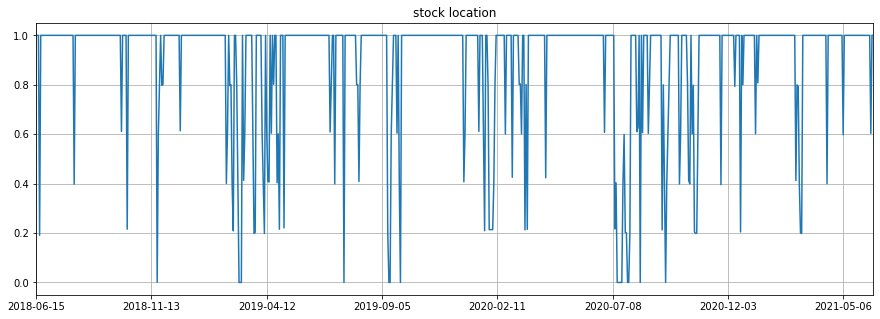

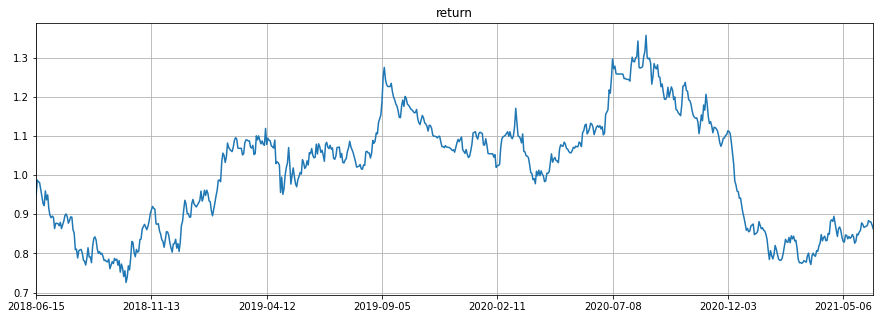

In [9]:
result = pd.DataFrame(index = datelist)
result["Money"] = money_list
result["Market"] = market_list
result["Total"] = result["Money"] + result["Market"]
result["hold_p"] = result["Market"] / result["Total"]
fig = plt.figure()
result["hold_p"].plot(figsize=(15,5),grid=True,title='stock location')
fig = plt.figure()
result["Total"].plot(figsize=(15,5),grid=True,title='return')
drawdown = result['Total'] / result['Total'].cummax() - 1
print('回测收益：',str(round(list(result['Total'])[-1] - 1,5)*100)+'%')
print('最大回撤：',str(round(abs(drawdown.min()),5)*100)+'%')